## Compagnie Malienne pour le Developpement des Textiles (CMDT) Mali Yield Data
### Region

Study area is the mandate area of the Compagnie Malienne de Développement des Textiles (CMDT) – Malian Company for the Development of Textiles located in Southern Mali. It consists of 5 CMDT regions/zones and 28 CMDT sectors. For each zone and sector, statistics such as average, minimum, maximum yield data is provided for each year spanning from 1990 to 2017.

A brief summary of the zones:

    - Sikasso has the highest average yields at 2324 units.
    - Koutiala is next at 1936 units on average.
    - Fana averages 1805 units.
    - Bougouni averages 2005 units.
    - San has the lowest average yields at 1690 units.

In [2]:
using_colab = True
if using_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import csv
import re
import os
from IPython.display import display, Markdown, HTML
import geopandas as gpd
import matplotlib.pyplot as plt

import warnings

# Filter out FutureWarnings related to the append method
warnings.filterwarnings("ignore", message="The frame.append method is deprecated and will be removed from pandas in a future version.", category=FutureWarning)


In [4]:
def convert_date(date_str):
    if int(date_str.split('/')[0])==99:
        harvest_year = '19' + date_str.split('/')[0]
    else:
        harvest_year = '19' + date_str.split('/')[0]

    return harvest_year

def preprocess_data(data):
    data.columns = data.columns.str.lower()
    return data

In [5]:
def preprocess_data(data):
    data.columns = data.columns.str.lower()
    return data

In [6]:
pwd

'/content'

#### Plot the area of interest and export the boundary shapefile for administrative codes

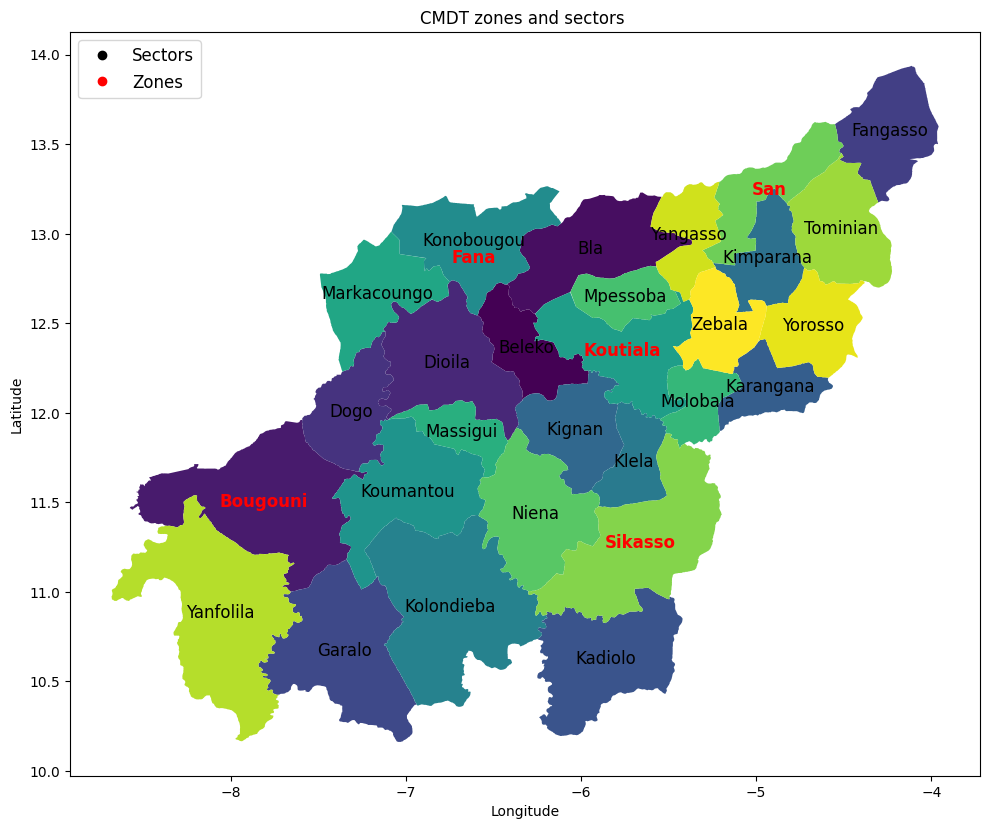

In [10]:
#the cmdt boundary
cmdt_boundary = preprocess_data(gpd.read_file("your_data_path/cmdt.geojson"))
cmdt_boundary = cmdt_boundary.drop('cmdtsecto2',axis= 1)
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
cmdt_boundary.columns = ['cmdt_sector','geometry']

#add sector codes
codes = pd.read_excel('your_data_path/codesecteur.xls')
# Drop rows where 'Secteur' is all uppercase
codes = codes[~codes['Secteur'].str.isupper()]
# Apply the lowercase and replace 'é' with 'e'
codes['Secteur'] = codes['Secteur'].str.lower().apply(lambda x: re.sub(r'é', 'e', x)).apply(lambda x: re.sub(r'[^a-zA-Z]', '', x)).str.title()
# Replace 'Diola' with 'Dioila'
codes.loc[codes['Secteur'] == 'Diola', 'Secteur'] = 'Dioila'
codes.columns =['sector_code', 'cmdt_sector']
# Merge the codes data with boundary data
updated_boundary_data = pd.merge(cmdt_boundary, codes, how='left')

# Plot the cmdt region with different colors for each sector
updated_boundary_data.plot(column='cmdt_sector', cmap='viridis', ax=ax, legend=False)

# Define the zone names and their corresponding colors
zone_names = ['Bougouni', 'Sikasso', 'Koutiala', 'San']
zone_color = 'red'

# Add sector names on top of the image
for idx, row in updated_boundary_data.iterrows():
    centroid = row.geometry.centroid
    sector_name = row['cmdt_sector']

    if sector_name in zone_names:
        # Display zone names in bold and red color
        ax.text(centroid.x, centroid.y, sector_name, ha='center', va='center', fontsize=12, fontweight='bold', color=zone_color)
    elif sector_name == 'Konobougou':
        # Display "Konobougou" in default style and "Fana" in bold and red color
        ax.text(centroid.x, centroid.y, 'Konobougou', ha='center', va='center', fontsize=12)
        ax.text(centroid.x, centroid.y - 0.1, 'Fana', ha='center', va='center', fontsize=12, fontweight='bold', color=zone_color)
    else:
        # Display other sector names in the default style
        ax.text(centroid.x, centroid.y, sector_name, ha='center', va='center', fontsize=12)

# Create legend handles and labels
sector_handle = plt.Line2D([], [], color='black', marker='o', linestyle='None', label='Sectors')
zone_handle = plt.Line2D([], [], color='red', marker='o', linestyle='None', label='Zones')

# Add legend to the plot
ax.legend(handles=[sector_handle, zone_handle], loc='upper left', fontsize=12)

# Customize the plot
plt.title('CMDT zones and sectors ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.tight_layout()
plt.show()

## Data
#### Variables included

    - crop_name: Maize
    - administrative boundary_code:(adm_id) Mali, region, cirle (district),sectors(commune)_ 3rd level
    - sector_code: included as sector code
    - season_name:  rainy, starts in May/June and lasts until September/October
    - planting_year: included
    - planting_date: to be extracted from crop calendar
    - harvest_date: to be extracted from crop calendar
    - yield: crop yield in mt/ha
    - production: from 1990-1999
    - planted_area: from 1990-1999
    - harvest_area: not available


#### 1. CMDT region/**zones** aggregated yield statistics per year (1990-2017)

In [12]:
# Read the CSV data
df = pd.read_csv("your_data_path/Statistics_CMDTzone_PerYear.csv")
# Delete the last row that has the average
df = df[:-1]
# Create an empty dictionary to store the data
data = []

# Get the unique sectors
zones = df.columns
zones = [re.sub(r'\.\d+', '', item) for item in zones]
df.columns = zones

# Iterate over each sector
for zone in zones:
    # Filter the data for the current sector
    zones_data = df.loc[:, df.columns.str.startswith(zone)]

    # Extract the required columns
    harvest_year = zones_data.iloc[1:, 0].tolist()
    AverageYield = zones_data.iloc[1:, 1].tolist()
    MinYield = zones_data.iloc[1:, 2].tolist()
    MaxYield = zones_data.iloc[1:, 3].tolist()
    STDeviationYield = zones_data.iloc[1:, 4].tolist()
    Coefiscient_VariationYield = zones_data.iloc[1:, 5].tolist()

    # Convert string values to float
    AverageYield = [float(value) for value in AverageYield]
    MinYield = [float(value) for value in MinYield]
    MaxYield = [float(value) for value in MaxYield]
    STDeviationYield = [float(value) for value in STDeviationYield]
    Coefiscient_VariationYield = [float(value) for value in Coefiscient_VariationYield]

    # Create a list of dictionaries for each row of data
    zone_data = [
        {
            'cmdt_zone': zone,
            'harvest_year': harvest_year[i],
            'average_yield': AverageYield[i],
            'min_yield': MinYield[i],
            'max_yield': MaxYield[i],
            'stdeviation_yield': STDeviationYield[i],
            'coefiscient_variation_yield': Coefiscient_VariationYield[i]
        }
        for i in range(len(harvest_year))
    ]

    # Extend the formatted data list with the sector data
    data.extend(zone_data)

# Create a DataFrame from the formatted data
cmdt_zones_yield_stats = pd.DataFrame(data)

#cmdt_zones_yield_stats.to_csv('cmdt_shapefile/region_yield_statistics')
cmdt_zones_yield_stats

,cmdt_zone,harvest_year,average_yield,min_yield,max_yield,stdeviation_yield,coefiscient_variation_yield
0,Bougouni,1990,1725.750000,1643.000000,1897.000000,115.635563,6.700598
1,Bougouni,1991,1455.800000,1406.000000,1544.000000,56.046409,3.849870
2,Bougouni,1992,1741.800000,1305.000000,2185.000000,342.284531,19.651196
3,Bougouni,1993,1712.744186,1537.011494,1836.000000,118.321215,6.908283
4,Bougouni,1994,1844.191422,1709.000000,1940.000000,94.687985,5.134390
...,...,...,...,...,...,...,...
835,Sikasso,2013,2311.306574,2123.497268,2474.382986,153.428640,6.638178
836,Sikasso,2014,2638.154769,2495.156522,2932.729258,173.587896,6.579898
837,Sikasso,2015,2710.983563,2514.635258,2951.583333,165.740248,6.113657
838,Sikasso,2016,2760.413792,2674.439024,2957.521008,116.125345,4.206809


#### 2. CMDT sectors average yield data  per year from 1990-2017

In [13]:
#global boundaries for codes
admn3_boundary = preprocess_data(gpd.read_file("your_data_path/admn3_boundary.geojson"))

#selected the columns of interest
admn3_boundary= admn3_boundary[['cmdtsector','adm1_fr','adm2_fr','adm3_fr','adm3_pcode']]
admn3_boundary.columns =['cmdt_sector','adm1_fr','adm2_fr','adm3_fr','adm_id']


# read the data
average_yield_df = preprocess_data(pd.read_csv("your_data_path/CMDT_Yield_Aggregated_1990-2017.csv"))
average_yield_df.columns= ['harvest_year', 'cmdt_zone', 'cmdt_sector', 'yield']
# Rename some columns
mapping = {'Zbala': 'Zebala', 'Nina': 'Niena', 'Tominia': 'Tominian', 'Kolondiba': 'kolondieba'}
# Replace values in the sector column
average_yield_df['cmdt_sector'] = average_yield_df['cmdt_sector'].replace(mapping)

# Merge the average yield with boundary data
updated_yld_df = pd.merge(average_yield_df, admn3_boundary, how='left')

# Define a function to prioritize matches
def prioritize_match(row, df):
    sector_matches = df[(df['adm3_fr'] == row['adm3_fr']) | (df['adm3_fr'] == row['cmdt_zone'])]
    if not sector_matches.empty:
        sector_match = sector_matches.iloc[0]
        return sector_match
    adm2_matches = df[(df['adm2_fr'] == row['adm2_fr']) | (df['adm2_fr'] == row['cmdt_zone'])]
    if not adm2_matches.empty:
        adm2_match = adm2_matches.iloc[0]
        return adm2_match
    adm1_matches = df[(df['adm1_fr'] == row['adm1_fr']) | (df['adm1_fr'] == row['cmdt_zone'])]
    if not adm1_matches.empty:
        adm1_match = adm1_matches.iloc[0]
        return adm1_match
    return pd.Series(dtype='object')  # Return empty series if no match found

# Initialize an empty DataFrame to store the filtered data
#filtered_data_frames = []#pd.DataFrame()
filtered_data_frames = pd.DataFrame()

# Iterate over unique sectors
for sector in updated_yld_df['cmdt_sector'].unique():
    sector_df = updated_yld_df[updated_yld_df['cmdt_sector'] == sector]
    # print(sector_df.head())
    # Apply the function to each row in the DataFrame
    filtered_df = pd.DataFrame(columns=updated_yld_df.columns)  # Initialize an empty DataFrame

    for year in sector_df['harvest_year'].unique():
        year_df = sector_df[sector_df['harvest_year'] == year]
        filtered_row = prioritize_match(year_df.iloc[0], year_df)
        filtered_row_df = pd.DataFrame(filtered_row, index=filtered_row.index).transpose()
        filtered_df = pd.concat([filtered_df,filtered_row_df])

    # Drop duplicate rows while keeping only the first occurrence for each year
    filtered_df = filtered_df.drop_duplicates(subset=['harvest_year'], keep='first')

    # Store the filtered DataFrame


    filtered_data_frames =pd.concat([filtered_data_frames,filtered_df]).reset_index(drop=True)

# Concatenate all filtered DataFrames for each sector
final_filtered_df = filtered_data_frames.dropna(how='all')
yield_data = pd.merge(final_filtered_df,average_yield_df,how='left')
final_yield_data_ = yield_data.drop(columns=['adm1_fr','adm2_fr', 'adm3_fr'])
final_yield_data_.head(10)

,harvest_year,cmdt_zone,cmdt_sector,yield,adm_id
0,1990,Bougouni,Bougouni,1685.0,ML030122
1,1991,Bougouni,Bougouni,1406.0,ML030122
2,1992,Bougouni,Bougouni,1846.0,ML030122
3,1993,Bougouni,Bougouni,1836.0,ML030122
4,1994,Bougouni,Bougouni,1940.0,ML030122
5,1995,Bougouni,Bougouni,1638.0,ML030122
6,1996,Bougouni,Bougouni,1775.0,ML030122
7,1997,Bougouni,Bougouni,1830.0,ML030122
8,1998,Bougouni,Bougouni,1947.0,ML030122
9,1999,Bougouni,Bougouni,2778.0,ML030122


#### 3. CMDT sectors aggregated production, planted area  and yield data

The production and planted area data is available from 1974 to 1999. And so we only provide the data from 1990 to match with the yield statistics.

In [14]:
areas = pd.read_excel("your_data_path/planted_area_data.xls")
areas = areas.fillna(0)
areas = pd.melt(
    areas,
    id_vars=['Secteur'],
    var_name='data',
    value_name='planted_area'
)
areas['date'] = areas['data'].apply(lambda x: convert_date(x))
areas.drop('data', axis=1, inplace=True)
areas['Secteur'] = areas['Secteur'].str.replace("'", "").str.replace('é', 'e').str.replace('ï', 'i')
areas.columns = ['cmdt_sector','planted_area','harvest_year']

areas_ = areas.copy()
# Drop rows with capital letter in the 'CMDT_Zone' column
areas_ = areas_[~areas_['cmdt_sector'].str.isupper()]

# Convert 'date' column to numeric values
areas_['harvest_year'] = pd.to_numeric(areas_['harvest_year'], errors='coerce')

# Drop rows before 1990
areas_ = areas_[areas_['harvest_year'] >= 1990]

# Reset the index if needed
areas_ = areas_.reset_index(drop=True)
areas_.to_csv('sectors_areas.csv')
prod_df = pd.read_excel("your_data_path/Production_data.xls")
prod_df = prod_df.fillna(0)
prod_df = pd.melt(
    prod_df,
    id_vars=['Secteur'],
    var_name='data',
    value_name='production'
)
prod_df['date'] = prod_df['data'].apply(lambda x: convert_date(x))
prod_df.drop('data', axis=1, inplace=True)
prod_df.columns = ['cmdt_sector','production','harvest_year']
prod_df['cmdt_sector'] = prod_df['cmdt_sector'].str.replace("'", "").str.replace('é', 'e').str.replace('ï', 'i')
prod_df = prod_df.copy()
prod_df = prod_df[~prod_df['cmdt_sector'].str.isupper()]
# Convert 'date' column to numeric values
prod_df['harvest_year'] = pd.to_numeric(prod_df['harvest_year'], errors='coerce')

# Drop rows before 1990
prod_df = prod_df[prod_df['harvest_year'] >= 1990]
clean_data =pd.merge(prod_df,areas_,how='left')
clean_df = clean_data[['cmdt_sector','harvest_year', 'production',  'planted_area']]

final_dff = pd.merge(final_yield_data_,clean_df,how='left')
final_dff['season_name']='Main'
final_dff['crop_name']='Maize'
final_dff['country_code']='ML'
final_dff = final_dff[['country_code', 'cmdt_zone', 'cmdt_sector','adm_id','season_name','harvest_year','crop_name', 'production', 'planted_area','yield']]
final_dff.head(10)

,country_code,cmdt_zone,cmdt_sector,adm_id,season_name,harvest_year,crop_name,production,planted_area,yield
0,ML,Bougouni,Bougouni,ML030122,Main,1990,Maize,7838.0,4652.0,1685.0
1,ML,Bougouni,Bougouni,ML030122,Main,1991,Maize,5257.0,3738.0,1406.0
2,ML,Bougouni,Bougouni,ML030122,Main,1992,Maize,8462.0,4584.0,1846.0
3,ML,Bougouni,Bougouni,ML030122,Main,1993,Maize,8064.0,4392.0,1836.0
4,ML,Bougouni,Bougouni,ML030122,Main,1994,Maize,9273.0,4779.0,1940.0
5,ML,Bougouni,Bougouni,ML030122,Main,1995,Maize,8198.0,5005.0,1638.0
6,ML,Bougouni,Bougouni,ML030122,Main,1996,Maize,9130.0,5143.0,1775.0
7,ML,Bougouni,Bougouni,ML030122,Main,1997,Maize,13546.0,7402.0,1830.0
8,ML,Bougouni,Bougouni,ML030122,Main,1998,Maize,16372.0,8409.0,1947.0
9,ML,Bougouni,Bougouni,ML030122,Main,1999,Maize,23389.0,8064.0,2778.0


Combine all datasets for saving

In [16]:
# Combine the datasets
combined_df = final_dff.merge(updated_boundary_data, how='left')

# Drop any rows with missing geometries
combined_df = combined_df.dropna(subset=['geometry'])

# Reset the index
combined_df = combined_df.reset_index(drop=True)
# Convert combined_df to a GeoDataFrame
combined_gdf = gpd.GeoDataFrame(combined_df, geometry='geometry')
# Convert sector_code to string
combined_gdf['sector_code'] = combined_gdf['sector_code'].astype(str)
# Combine adm_id and sector_code into a single adm_id column
combined_gdf['adm_id'] = combined_gdf.apply(lambda row: row['adm_id'] + row['sector_code'], axis=1)

# Drop the sector_code column
combined_gdf = combined_gdf.drop('sector_code', axis=1)

# Convert data types of integer columns to int32
unsupported_cols = combined_gdf.select_dtypes(include=['object', 'datetime64']).columns
combined_gdf[unsupported_cols] = combined_gdf[unsupported_cols].astype(str)

# Remove duplicate rows based on adm_id to save shapefile
cmdt_bound = combined_gdf[['country_code', 'cmdt_zone', 'cmdt_sector', 'adm_id','geometry']].drop_duplicates(subset='adm_id', keep='first').reset_index(drop=True)
# Save the GeoDataFrame as a shapefile
cmdt_bound.to_file('your_data_path/output/cmdt_boundary.shp')
# Save the GeoDataFrame as a shapefile
combined_gdf[['country_code', 'cmdt_zone', 'cmdt_sector', 'adm_id', 'season_name',
       'harvest_year', 'crop_name', 'production', 'planted_area', 'yield']].to_csv('your_data_path/output/aggregated_yield_production_maize_data_ml.csv')

<ipython-input-16-2b9b39a450df>:26: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cmdt_bound.to_file('/content/drive/MyDrive/CRAFT/suivi-opérationnel-cmdt/maize_data/output/cmdt_boundary.shp')
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'country_code' to 'country_co'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'cmdt_sector' to 'cmdt_secto'
  ogr_write(
